In [1]:
# Analysis of RNA embeddings

# Constact equation RNA1+RNA2+RNA3=0
# where RNA1 is from dg_unique and RNA1,RNA2 from dg_base dataframes

import sys
import os
from tqdm import tqdm
import requests


sys.path.append(os.path.abspath('../'))
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from lib.embed_arithmetic import get_description
import re




In [3]:
# Read data
path = "../data/raw/data_rna_central/general_dataframes/"

# ADD sequences of interest (PTC sequences)
files_unique = "general_rnafm_unique.csv"
dg_unique = pd.read_pickle(path+files_unique).drop(index=1).reset_index(drop=True)

# ADD random sequences
files_random = ["general_rnafm_couples_6nucl_full.csv","general_rnafm_random_8nucl_full.csv"]
dg_base = pd.read_pickle(path+files_random[1])
# filtre by length
# dg_base = dg_base[(dg_base['sequence'].str.len() > 0)&(dg_base['sequence'].str.len() <= 8)]
dg_base = dg_base.reset_index(drop=True)
dg_base = dg_base.drop(dg_base.index) # make dataframe empty

# ADD sequences extracted from RNAcentral database
extract_types = ['tRNA']
#extract_types = []
# files: general_rnafm_0_2000.csv, general_rnafm_2000_4000.csv, ...
Nfiles = 1 # number of files to read
max_value = Nfiles * 2000 # max number of RNA molecules to load (divisiable by 2000)
step = 2000 # number of RNA molecules in each file
files_db = [f"general_rnafm_{i}_{i+step}.csv" for i in range(0, max_value, step)] # files to download
N_RNA_missing = 0 # keep track of number RNAs not downloaded from RNAcentral 
if len(extract_types)>0:
    for file in tqdm(files_db):
        df = pd.read_pickle(path+file)# [N_start: N_end]
        # quatify extraction problems
        perecent_missing = 100*(100000-len(df))/100000
        N_RNA_missing += 100000 * perecent_missing / 100
        df = df.loc[df["embedding"].apply(lambda x: isinstance(x, np.ndarray))]
        df = df.loc[df.rna_type.isin(extract_types)]
        df = df.reset_index(drop=True)

        dg_base = pd.concat([dg_base, df, ], ignore_index=True)


# Concatenate dataframes of interest
#dg_base = pd.concat([dg_unique.loc[8:8], dg_unique.loc[8:8], dg_unique.loc[8:8], dg_base], ignore_index=True)
#dg_base = pd.concat([dg_unique, dg_base], ignore_index=True)
#dg_base = dg_base.loc[dg_base.rna_type!="SymR_PA"]
dg_base = dg_base.reset_index(drop=True)
    
print("N_RNA_missing ", int(N_RNA_missing))
print("length of dg:", len(dg_base), "RNA molecules")
print("rna types:", pd.Series(dg_base.rna_type).unique())




100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

N_RNA_missing  50
length of dg: 42317 RNA molecules
rna types: ['tRNA']


In [4]:
# Decrease dataframe size
# Keep only random L rows for each rna type
L = 10000 

# Select up to L rows per group
dg_base = dg_base.groupby("rna_type").apply(lambda x: x.sample(n=min(L, len(x)), random_state=42)).reset_index(drop=True)

print(len(dg_base))
print("rna types:", pd.Series(dg_base.rna_type).unique())

10000
rna types: ['tRNA']


In [ ]:
"""from models.lib.embed_arithmetic import get_description

dg["remove"] = False
organisms = ["yanothece sp. PCC 7822",
             "icrocoleus chthonoplastes PCC 7420",
             "cytonema millei VB511283"]
#organisms = ["yanothece",
#             "icrocoleus",
#             "cytonema"]
for i in tqdm(range(len(dg))):
    if dg["rna_type"].iloc[i]=="sRNA":
        xrefs = dg["xrefs"].iloc[i]
        if xrefs:
            s = get_description(xrefs)
            dg.at[i, "remove"] = True
            if any(organism in s for organism in organisms):
                #print(s)
                dg.at[i, "remove"] = False"""


In [5]:
# Calculate dimentionality reduction

"""vectors = np.stack(dg_base["embedding"].values)
print("Before dimentionality reduction:", vectors.shape)

umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
vectors = umap_model.fit_transform(vectors)
print("After dimentionality reduction:", vectors.shape)"""


vectors_base = np.stack(dg_base["embedding"].values)
vectors_check = np.stack(dg_unique["embedding"].values)
print("Before dimentionality reduction:", vectors_base.shape)


umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
vectors_base_fitT = umap_model.fit_transform(vectors_base)
print("After UMAP dimentionality reduction:", vectors_base_fitT.shape)
vectors_check_T = umap_model.transform(vectors_check) 





Before dimentionality reduction: (10000, 640)


c:\Users\User\miniconda3\envs\rna\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\miniconda3\envs\rna\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


After UMAP dimentionality reduction: (10000, 2)


c:\Users\User\miniconda3\envs\rna\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


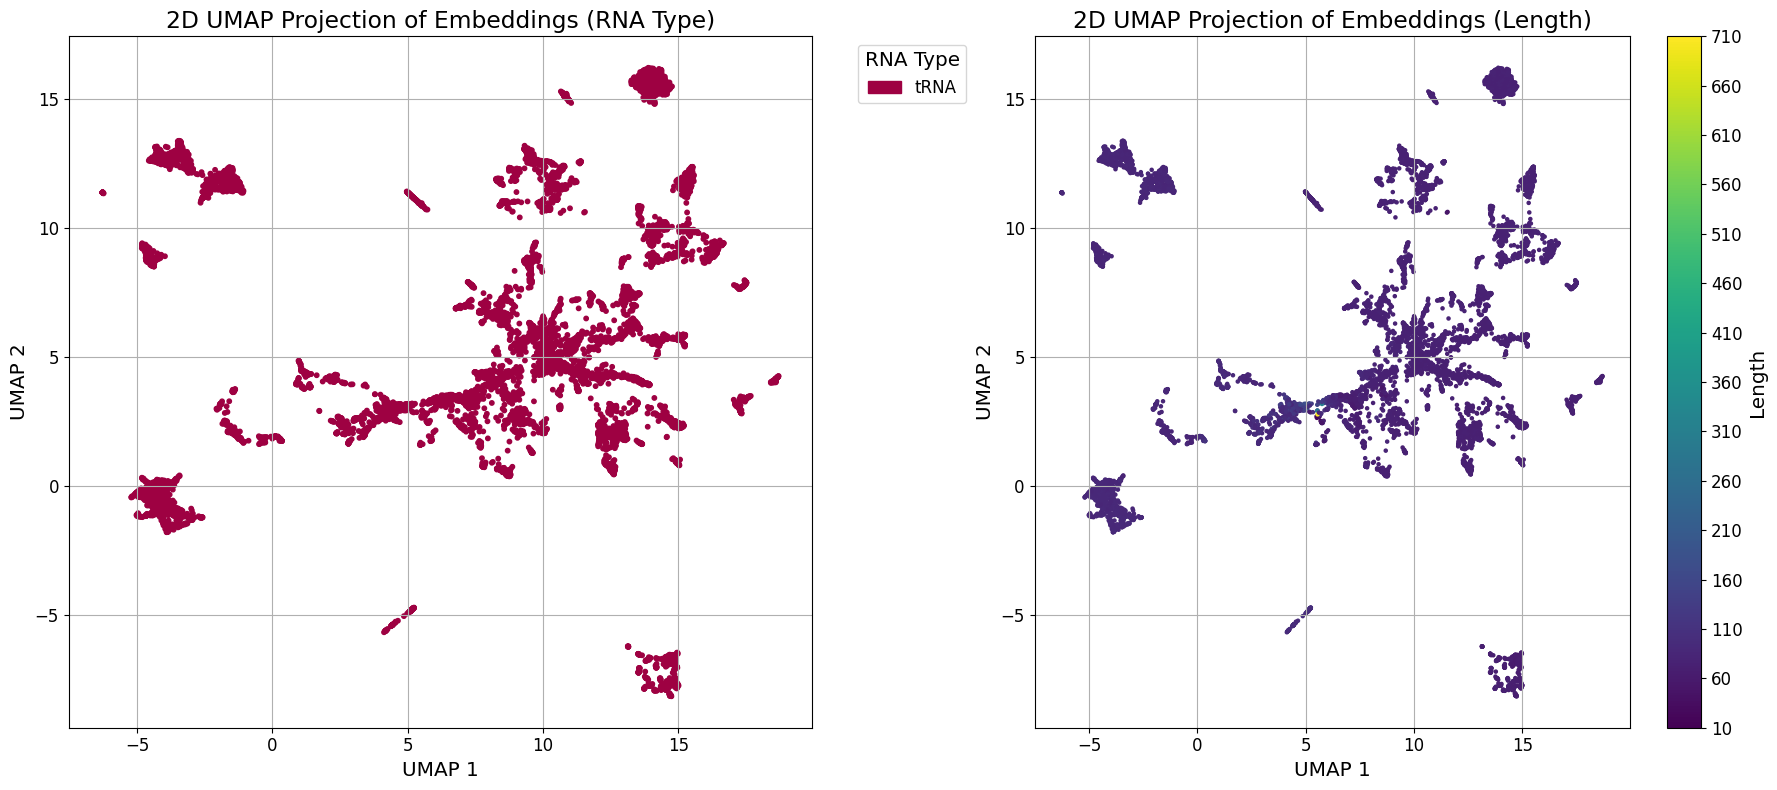

In [6]:
# Make 2D plot after dimensionality reduction
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Define scaling factor for font sizes (20% increase)
scale_factor = 1.2

# First plot: Colored by `rna_type`
ax1 = axes[0]
rna_types = pd.Series(dg_base['rna_type']).astype('category')
rna_codes = rna_types.cat.codes  # Numeric codes for categories
cmap = plt.cm.Spectral  # Colormap
norm = plt.Normalize(vmin=rna_codes.min(), vmax=rna_codes.max())  # Normalize color scale

scatter1 = ax1.scatter(vectors_base_fitT[:, 0], vectors_base_fitT[:, 1], c=rna_codes, cmap=cmap, norm=norm, s=10)
ax1.set_title('2D UMAP Projection of Embeddings (RNA Type)', fontsize=14 * scale_factor)
ax1.set_xlabel('UMAP 1', fontsize=12 * scale_factor)
ax1.set_ylabel('UMAP 2', fontsize=12 * scale_factor)
ax1.tick_params(axis='both', labelsize=10 * scale_factor)  # Scale tick labels
ax1.grid(True)

# Create a legend with consistent colors
unique_rna_types = rna_types.cat.categories
patches = [mpatches.Patch(color=cmap(norm(code)), label=rna_type) 
           for rna_type, code in zip(unique_rna_types, range(len(unique_rna_types)))]

legend = ax1.legend(handles=patches, title="RNA Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10 * scale_factor)
legend.get_title().set_fontsize(12 * scale_factor)  # Scale legend title

# Second plot: Colored by `length`
# Compute sequence lengths
sequence_lengths = np.array([len(seq) for seq in dg_base['sequence']])
ax2 = axes[1]

# Use percentiles to remove extreme outliers
vmin, vmax = np.percentile(sequence_lengths, [0, 100])

# Round vmin and vmax to nearest multiple of 10
vmin = int(np.floor(vmin / 10) * 10)
vmax = int(np.ceil(vmax / 10) * 10)

# **Adaptive Step Calculation**: Adjust step size based on range
value_range = vmax - vmin

if value_range <= 100:
    step = 10  # Small range → keep step small
elif value_range <= 500:
    step = 25  # Moderate range → increase step
elif value_range <= 2000:
    step = 50  # Large range → bigger step
else:
    step = 100  # Very large range → even bigger step

# Normalize colors based on adjusted range
norm = plt.Normalize(vmin=vmin, vmax=vmax)

scatter2 = ax2.scatter(vectors_base_fitT[:, 0], vectors_base_fitT[:, 1], c=sequence_lengths, cmap='viridis', norm=norm, s=5)
ax2.set_title('2D UMAP Projection of Embeddings (Length)', fontsize=14 * scale_factor)
ax2.set_xlabel('UMAP 1', fontsize=12 * scale_factor)
ax2.set_ylabel('UMAP 2', fontsize=12 * scale_factor)
ax2.tick_params(axis='both', labelsize=10 * scale_factor)  # Scale tick labels
ax2.grid(True)

# Add color bar with adjusted scaling
cbar = plt.colorbar(scatter2, ax=ax2)
cbar.set_label('Length', fontsize=12 * scale_factor)
cbar.ax.tick_params(labelsize=10 * scale_factor)  # Scale color bar ticks

# Generate tick marks with adaptive step size
tick_values = np.arange(vmin, vmax + 1, step)
cbar.set_ticks(tick_values)
cbar.set_ticklabels([str(int(tick)) for tick in tick_values])  # Ensure integer labels

plt.tight_layout()
plt.show()

In [ ]:
# Search for triangles of vectors
######### vector_1 = vector_2 + vector_3 ###############

In [7]:
from models.lib.embed_arithmetic import compute_vector_combinations

# Compute all possible vector combinations for two vectors
# vectors_base_fitT with vectors_base_fitT
# avoiding counting the same vector twice
# (0, 1, '-', '-') means -vector[0]-vector[1], ...

sum_vectors, pairs = compute_vector_combinations(vectors_base_fitT, vectors_base_fitT, Lbound=800)
print(sum_vectors.shape)
print(pairs[:20])

100%|██████████| 800/800 [00:07<00:00, 102.28it/s]


(1278400, 2)
[(0, 1, '-', '-'), (0, 1, '-', '+'), (0, 1, '+', '-'), (0, 1, '+', '+'), (0, 2, '-', '-'), (0, 2, '-', '+'), (0, 2, '+', '-'), (0, 2, '+', '+'), (0, 3, '-', '-'), (0, 3, '-', '+'), (0, 3, '+', '-'), (0, 3, '+', '+'), (0, 4, '-', '-'), (0, 4, '-', '+'), (0, 4, '+', '-'), (0, 4, '+', '+'), (0, 5, '-', '-'), (0, 5, '-', '+'), (0, 5, '+', '-'), (0, 5, '+', '+')]


In [8]:
# Build KDTree
tree = KDTree(sum_vectors)

In [9]:
# Search for nearest neighbors
# in order to constact equation RNA1+RNA2+RNA3=0
# where RNA1 is from dg_unique and RNA1,RNA2 from dg_base

results = []
norm_min = 1e9
for el in vectors_base_fitT:
    norm = np.linalg.norm(el)
    if norm<norm_min:
        norm_min = norm
dist_min = norm_min / 20
print("dist_min", dist_min) # to consider two vectors to be equal

for i, vec in tqdm(enumerate(vectors_check_T)):

    dist, idx = tree.query(vec.reshape(1, -1), k=1)
    if dist[0][0]>0 and dist[0][0]<dist_min:
        j, k, sign1, sign2  = pairs[idx[0][0]]
        results.append(('-', i, sign1, j, sign2, k))

print(results)

dist_min 0.08389073014259338


8it [00:00, 8000.58it/s]

[('-', 0, '-', 433, '+', 594), ('-', 1, '+', 7, '+', 319), ('-', 2, '-', 529, '+', 715), ('-', 3, '+', 353, '+', 479), ('-', 4, '-', 284, '+', 354), ('-', 5, '-', 3, '+', 544), ('-', 6, '+', 4, '-', 95), ('-', 7, '-', 326, '+', 402)]


In [ ]:
# Get equations: RNA1 = RNA2 + RNA3
from models.lib.embed_arithmetic import get_description
from collections import Counter

RNA_indexes_eqs = []
RNA_types_eqs_exclude = []

# Get the frequency of each RNA in all equations
stat = {}
for i in range(len(dg_base)):
    stat[i] = 0

for el in results:
    print(el)
    RNA0_index, RNA1_index, RNA2_index = el[1], el[3], el[5]
    sign0, sign1, sign2 = el[0], el[2], el[4]
    RNA0_length = len(dg_unique["sequence"].iloc[RNA0_index])
    RNA1_length = len(dg_base["sequence"].iloc[RNA1_index])
    RNA2_length = len(dg_base["sequence"].iloc[RNA2_index])
    RNA_types_eq = sign0 + dg_unique["rna_type"].iloc[RNA0_index] + \
        sign1 + dg_base["rna_type"].iloc[RNA1_index]+ \
            sign2 + dg_base["rna_type"].iloc[RNA2_index] + " = 0"
    RNA_lengths = sign0 + str(RNA0_length) + \
        sign1 + str(RNA1_length) + \
            sign2 + str(RNA2_length) + " = 0"
    RNA_indexes_eq = sign0 + str(RNA0_index) + \
        sign1 + str(RNA1_index) + \
            sign2 + str(RNA2_index) + " = 0"

    #if (RNA_types_eq not in RNA_types_eqs_exclude):
    if 1: #"sRNA" in RNA_types_eq:
        RNA0_description = get_description(url=dg_unique.xrefs.iloc[RNA0_index])
        RNA1_description = get_description(url=dg_base.xrefs.iloc[RNA1_index])
        RNA2_description = get_description(url=dg_base.xrefs.iloc[RNA2_index])

        species = [RNA0_description.split(" ")[0], 
                   RNA1_description.split(" ")[0], 
                   RNA2_description.split(" ")[0]]
        counts = Counter(species)
        condition_same_species = max(counts.values())>1
        #c0 = "RNase P RNA" in RNA0_description
        #c0 = any(organism in RNA0_description for organism in organisms)
        #c1 = any(organism in RNA1_description for organism in organisms)
        #c2 = any(organism in RNA2_description for organism in organisms)
        condition1 = (RNA0_description.split(" ")[0]==RNA1_description.split(" ")[0])
        condition2 = (RNA0_description.split(" ")[0]==RNA2_description.split(" ")[0])
        # if ("RNase_P_RNA" in RNA_types_eq) and (condition_same_species): 
        #if (condition_same_species): 
        #if (c0 and c1) or (c1 and c2) or (c0 and c2): 
        #if c0 or c1 or c2: 
        if 1:

            #condition1 and condition2:
            # Find the most frequent RNA
            stat[RNA0_index] = stat[RNA0_index] + 1
            stat[RNA1_index] = stat[RNA1_index] + 1
            stat[RNA2_index] = stat[RNA2_index] + 1

            print(RNA_types_eq)
            print("lengths:", RNA_lengths)
            print("index in dg:", RNA_indexes_eq)
            print("-->", RNA0_description)
            print("-->", RNA1_description)
            print("-->", RNA2_description)
            RNA_indexes_eqs.append(RNA_indexes_eq)
            print()

('-', 0, '-', 433, '+', 594)
-empty-tRNA+tRNA = 0
lengths: -0-66+73 = 0
index in dg: -0-433+594 = 0
--> 
--> Gaiellaceae bacterium tRNA-Arg
--> Cyclobacteriaceae bacterium tRNA-Gln

('-', 1, '+', 7, '+', 319)
-SymR_A+tRNA+tRNA = 0
lengths: -109+77+87 = 0
index in dg: -1+7+319 = 0
--> 
--> Vulgatibacter sp. tRNA-Met
--> Fimbriimonadaceae bacterium tRNA-Ser

('-', 2, '-', 529, '+', 715)
-SymR_P-tRNA+tRNA = 0
lengths: -444-99+79 = 0
index in dg: -2-529+715 = 0
--> 
--> Podospora australis tRNA-Asp
--> Halothiobacillus sp. tRNA-Arg

('-', 3, '+', 353, '+', 479)
-SymR_PA+tRNA+tRNA = 0
lengths: -553+78+91 = 0
index in dg: -3+353+479 = 0
--> 
--> Terriglobia bacterium tRNA-Glu
--> Deltaproteobacteria bacterium tRNA-Ser

('-', 4, '-', 284, '+', 354)
-PTC2-tRNA+tRNA = 0
lengths: -549-75+73 = 0
index in dg: -4-284+354 = 0
--> 
--> Solirubrobacteraceae bacterium tRNA-Arg
--> Deltaproteobacteria bacterium tRNA-Lys

('-', 5, '-', 3, '+', 544)
-PTC3-tRNA+tRNA = 0
lengths: -564-105+78 = 0
index in dg

In [19]:
# Create vectors to plot

triangle = 4 # choose tringle to plot
vectors0 = []

# 3val "-50207+2727+2815 = 0"
# "-286+897+4236 = 0", -145-1958+1988 = 0, -2785+492+4511 = 0
RNA_indexes_eq = RNA_indexes_eqs[triangle]
#RNA_indexes_eq = "2 + 1 + 3 = 0"

print("RNA_indexes_eq:", RNA_indexes_eq)
rna_indexes = [np.abs(int(match)) for match in re.findall(r'[-+]?\d+', RNA_indexes_eq)[:3]]
#rna_indexes = [ 190,86,87]

for i, rna_index in enumerate(rna_indexes):
    if i==0:
        vectors = vectors_check_T
        url = dg_unique["xrefs"].iloc[rna_index]
        label = get_description(url)
    else:
        vectors = vectors_base_fitT
        url = dg_base["xrefs"].iloc[rna_index]
        label = get_description(url)
    if rna_index>0:
        vec = (0, 0, vectors[rna_index][0], vectors[rna_index][1])
    else:
        vec = (vectors[-rna_index][0], vectors[-rna_index][1], 0, 0)
    vectors0.append( (label, vec) )

RNA_indexes_eq: -4-284+354 = 0


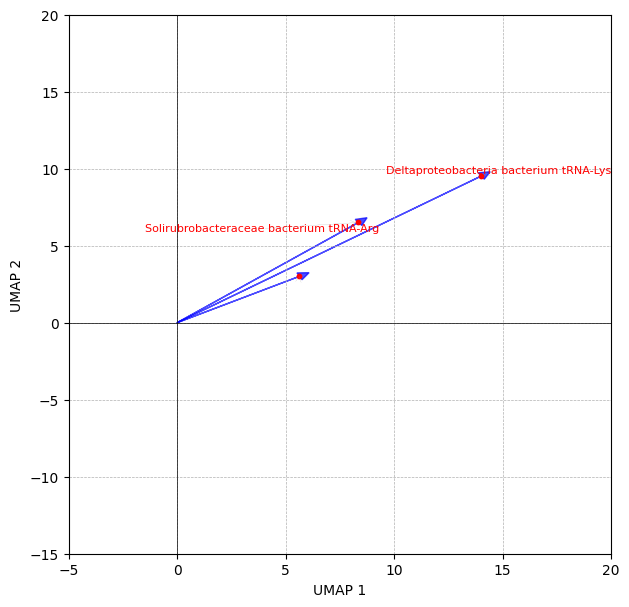

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

# Define vectors as (x_start, y_start, x_end, y_end)
#vectors0 = [v1646, v0, v2888, v4591]

# Create a plot
fig, ax = plt.subplots(figsize=(7, 7))
#ax.set_xlim(-10, 10)
#ax.set_ylim(-12, 20)
ax.set_xlim(-5, 20)
ax.set_ylim(-15, 20)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(True, linestyle='--', linewidth=0.5)

texts = []  # Store text elements for later adjustment

for label, (x_start, y_start, x_end, y_end) in vectors0:
    dx = x_end - x_start
    dy = y_end - y_start
    
    ax.arrow(x_start, y_start, dx, dy, head_width=0.5, head_length=0.5, fc='blue', ec='blue', alpha=0.7)
    ax.scatter(x_end, y_end, color='red', s=10) # s is size of red point
    
    # Create a text label and store it in the list for adjustment
    text = ax.text(x_end, y_end, label, fontsize=8, ha='center', va='center', color='red', fontweight='normal')
    texts.append(text)

# Adjust text labels to avoid overlaps
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.1))
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.1),
            expand_points=(1.5, 1.5),  # Increase this value to push labels further
            force_points=(0.3, 0.3),  # Apply a small force to move labels away from points
            force_text=(0.1, 0.1))  # Apply a small force between labels

# ax.set_title("Labeled Vectors Plot with Adjusted Labels")
ax.set_xlabel("UMAP 1", fontsize=10)  # Set x-axis label
ax.set_ylabel("UMAP 2", fontsize=10)  # Set y-axis label
plt.show()


In [24]:
# Find the most frequent RNA (index in dg_base) in all equations

stat_desc = dict(sorted(stat.items(), key=lambda item: item[1], reverse=True))

n = 0
key, value = list(stat_desc.items())[n]
key, df["rna_type"].iloc[key], value
stat_desc

{3: 2,
 4: 2,
 7: 2,
 0: 1,
 1: 1,
 2: 1,
 5: 1,
 6: 1,
 95: 1,
 284: 1,
 319: 1,
 326: 1,
 353: 1,
 354: 1,
 402: 1,
 433: 1,
 479: 1,
 529: 1,
 544: 1,
 594: 1,
 715: 1,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 11